In [154]:
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

data = pd.read_csv('ADBL.csv',sep = ',',header = 0)
data.tail()

,Company,Date,Transactions,TotalSharesTraded,TotalAmount,Open,MaxPrice,MinPrice,ClosePrice,EMA12,EMA26,EMA50
2197,ADBL,3/15/20,316,67992,26126277,397.0,394.0,378,382.0,406.610505,406.165428,406.165428
2198,ADBL,3/16/20,173,34352,13129517,382.0,391.0,371,382.0,402.824274,404.375397,404.375397
2199,ADBL,3/17/20,219,45920,17239532,382.0,380.0,370,378.0,399.005155,402.421663,402.421663
2200,ADBL,3/18/20,211,54659,20168668,378.0,385.0,361,374.0,395.158208,400.316355,400.316355
2201,ADBL,3/19/20,214,34900,12872297,374.0,385.0,360,376.0,392.210791,398.515144,398.515144


In [155]:
train_columns = ['Open','MaxPrice','MinPrice','ClosePrice','TotalSharesTraded']
split_factor = .8
df_ge = data[['Open','MaxPrice','MinPrice','ClosePrice','TotalSharesTraded']]
df_train = df_ge[:int(split_factor*len(df_ge))]
df_test  = df_ge[int(split_factor*len(df_ge)):]

x = df_train.loc[:].values
minmax_scaler = MinMaxScaler()

x_train = minmax_scaler.fit_transform(x)
x_test = minmax_scaler.fit_transform(df_test.loc[:])


In [156]:
Time_step = 26
def time_series_builder(mat,y_col_index):
    dim_0 = mat.shape[0] - Time_step
    dim_1 = mat.shape[1]

    x = np.zeros((dim_0,Time_step,dim_1))
    y = np.zeros((dim_0,))

    for i in range(dim_0):
        x[i] = mat[i:Time_step+i]
        y[i] = mat[Time_step+i,y_col_index]

    return x,y


def trim_dataset(mat, batch_size=20):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [157]:
x_t , y_t = time_series_builder(x_train,3)

x_t = trim_dataset(x_t)
y_t = trim_dataset(y_t)

x_temp, y_temp = time_series_builder(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, 20),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, 20),2)

In [158]:
y_test_t.shape

(200,)

In [85]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras import optimizers
# from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import logging

Using TensorFlow backend.


In [95]:
lstm_model = Sequential()
lstm_model.add(LSTM(100, batch_input_shape=(20, Time_step, x_t.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True,     kernel_initializer='random_uniform'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(20,activation = 'relu'))
lstm_model.add(Dense(1,activation='sigmoid'))
optimizer = optimizers.RMSprop(lr=0.00010000)

# adam = optimizers.Adam(lr=0.0005)
lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)


In [189]:
csv_logger = CSVLogger('model.log', append=True)

# history = model.fit(x_t, y_t, epochs = 40, verbose=2, batch_size=20,
#                     shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
#                     trim_dataset(y_val, BATCH_SIZE)), callbacks=[csv_logger])

lstm = lstm_model.fit(x_t, y_t, epochs = 40, batch_size = 20, shuffle=False,validation_data = (x_val,y_val))


Train on 1720 samples, validate on 200 samples
Epoch 1/40
1720/1720 [==============================] - 1s 668us/step - loss: 9.1514e-04 - val_loss: 0.0040
Epoch 2/40
1720/1720 [==============================] - 1s 616us/step - loss: 8.0064e-04 - val_loss: 0.0034
Epoch 3/40
1720/1720 [==============================] - 1s 588us/step - loss: 8.4235e-04 - val_loss: 0.0034
Epoch 4/40
1720/1720 [==============================] - 1s 588us/step - loss: 8.4730e-04 - val_loss: 0.0038
Epoch 5/40
1720/1720 [==============================] - 1s 580us/step - loss: 9.3760e-04 - val_loss: 0.0037
Epoch 6/40
1720/1720 [==============================] - 1s 585us/step - loss: 8.2738e-04 - val_loss: 0.0033
Epoch 7/40
1720/1720 [==============================] - 1s 642us/step - loss: 8.2411e-04 - val_loss: 0.0037
Epoch 8/40
1720/1720 [==============================] - 1s 630us/step - loss: 9.4064e-04 - val_loss: 0.0034
Epoch 9/40
1720/1720 [==============================] - 1s 619us/step - loss: 7.7929e-04 

In [190]:

y_pred = lstm_model.predict(x_test_t,batch_size=20)
# y_pred.shape
# y_test_t.shape
error = mean_squared_error(y_test_t, y_pred)
error


0.002365646944703224

In [191]:
y_pred_org = (y_pred * minmax_scaler.data_range_[3]) + minmax_scaler.data_min_[3]

y_test_t_org = (y_test_t * minmax_scaler.data_range_[3]) + minmax_scaler.data_min_[3]



In [1]:
from matplotlib import pyplot as plt
print(lstm.history.keys())
pickle.dump(model, open("lstm_model", "wb"))

NameError: name 'lstm' is not defined

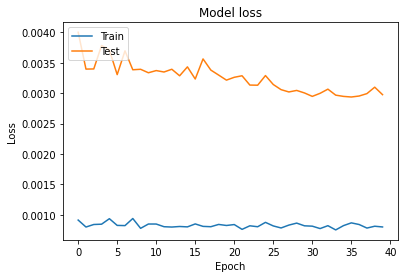

In [193]:
plt.figure()
plt.plot(lstm.history['loss'])
plt.plot(lstm.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

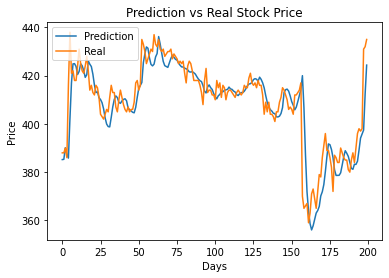

In [194]:
plt.figure()
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
#plt.show()
# plt.savefig(os.path.join(OUTPUT_PATH, 'pred_vs_real_BS'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))
# print_time("program completed ", stime)